# Spectral fitting example (4C+21.35, flare)


**To run this, you need the following files, which can be downloaded using the first few cells of this notebook:**
- orientation file (COSI-SMEX/DC3/Data/Orientation/DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori)       
- download unbinned data (COSI-SMEX/DC3/Data/Sources/4C21p35_flare_3months_unbinned_data_filtered_with_SAAcut.fits.gz, COSI-SMEX/DC3/Data/Sources/4C21p35_flare_3months_unbinned_data_filtered_with_SAAcut.fits.gz, COSI-SMEX/DC3/Data/Backgrounds/Ge/AlbedoPhotons_3months_unbinned_data_filtered_with_SAAcut.fits.gz), combine with background and binning     
- detector response (COSI-SMEX/DC3/Data/Responses/ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5.zip)     

**The binned data are simulations of the 4C+21.35 (flare) and albedo photon background produced using the COSI SMEX mass model. The detector response needs to be unzipped before running the notebook.**

This notebook fits the spectrum of a 4C+21.35 simulated using MEGAlib and combined with background.

[3ML](https://threeml.readthedocs.io/) is a high-level interface that allows multiple datasets from different instruments to be used coherently to fit the parameters of source model. A source model typically consists of a list of sources with parametrized spectral shapes, sky locations and, for extended sources, shape. Polarization is also possible. A "coherent" analysis, in this context, means that the source model parameters are fitted using all available datasets simultanously, rather than performing individual fits and finding a well-suited common model a posteriori. 

In order for a dataset to be included in 3ML, each instrument needs to provide a "plugin". Each plugin is responsible for reading the data, convolving the source model (provided by 3ML) with the instrument response, and returning a likelihood. In our case, we'll compute a binned Poisson likelihood:

$$
\log \mathcal{L}(\mathbf{x}) = \sum_i \log \frac{\lambda_i(\mathbf{x})^{d_i} \exp (-\lambda_i)}{d_i!}
$$

where $d_i$ are the counts on each bin and $\lambda_i$ are the expected counts given a source model with parameters $\mathbf{x}$. 

In this example, we will fit a single point source with a known location. We'll assume the background is known and fixed up to a scaling factor. Finally, we will fit a Powerlaw function:

$$
f(x) = K \left(\frac{x}{E_{piv}}\right)^{\alpha}
$$

where $K$ (normalization), $\alpha$ (spectral index), are the free parameters, while $E_{piv}$ is the pivot energy which is fixed (and arbitrary).

Considering these assumptions:

$$
\lambda_i(\mathbf{x}) = B*b_i + s_i(\mathbf{x})
$$

where $B*b_i$ are the estimated counts due to background in each bin with $B$ the amplitude and $b_i$ the shape of the background, and $s_i$ are the corresponding expected counts from the source, the goal is then to find the values of $\mathbf{x} = [K, \alpha]$ and $B$ that maximize $\mathcal{L}$. These are the best estimations of the parameters.

The final module needs to also fit the time-dependent background, handle multiple point-like and extended sources, as well as all the spectral models supported by 3ML. Eventually, it will also fit the polarization angle. However, this simple example already contains all the necessary pieces to do a fit.

In [1]:
from cosipy import COSILike, BinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.response.FullDetectorResponse import FullDetectorResponse
from cosipy.util import fetch_wasabi_file

from scoords import SpacecraftFrame

from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import poisson_conf_interval

import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

from threeML import Band, PointSource, Model, JointLikelihood, DataList
from cosipy import Band_Eflux
from astromodels import Parameter

from pathlib import Path

import os
import corner
from threeML import*
# from astromodels.functions.functions_1D import Log_parabola
# from astromodels.functions.functions_1D import Powerlaw
from astromodels import *


08:47:14 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=601351;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=583330;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#47\47]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=442817;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=728245;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#68\68]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=947530;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=289428;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

         INFO      Starting 3ML!                                                                     ]8;id=782459;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=344922;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#39\39]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=990145;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=65735;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=585549;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=459310;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#41\41]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=117948;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=624195;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#44\44]8;;\

08:47:14 WARNING   ROOT minimizer not available                                                ]8;id=249494;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=385115;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=752682;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=383760;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=754107;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=890911;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=511310;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=663872;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=570273;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=486514;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=319741;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=588230;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

08:47:15 WARNING   No fermitools installed                                              ]8;id=719457;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=652629;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

08:47:15 WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=844421;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=875792;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=698213;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=814450;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=719136;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=260542;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

## Get the data

Define the path to the directory to save the data. The data can be downloaded by running the cells below. Each respective cell also gives the wasabi file path and file size.

In [2]:
data_path = Path("/home/srinadb/cosipy/docs/tutorials/spectral_fits/dataset/")

Download the orientation file (684.38 MB)

In [3]:
# fetch_wasabi_file('COSI-SMEX/DC3/Data/Orientation/DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori', output=str(data_path /'DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori'))


Download the response file (839.62 MB). This needs to be unzipped before running the rest of the notebook

In [4]:
# fetch_wasabi_file('COSI-SMEX/DC3/Data/Responses/ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5.zip', output=str(data_path / 'ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5.zip'))


Read in the spacecraft orientation file

In [5]:
sc_orientation = SpacecraftFile.parse_from_file(data_path / "DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori")

Create BinnedData objects for the Crab only, Crab+background, and background only. The Crab only simulation is not used for the spectral fit, but can be used to compare the fitted spectrum to the source simulation

In [6]:
blazar = BinnedData("blazar.yaml")
blazar_bkg = BinnedData("blazar.yaml")
bkg = BinnedData("background.yaml")

Load binned .hdf5 files

In [7]:
blazar.load_binned_data_from_hdf5(binned_data="./4C21p35_flare_binned_data.hdf5")
blazar_bkg.load_binned_data_from_hdf5(binned_data="./4C21p35_flare_AlbedoPhoton_bkg_binned_data.hdf5")
bkg.load_binned_data_from_hdf5(binned_data="./AlbedoPhoton_bkg_binned_data.hdf5")

Define the path to the detector response

In [8]:
dr = str(data_path / "ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5") # path to detector response


## Perform spectral fit

Set background parameter, which is used to fit the amplitude of the background, and instantiate the COSI 3ML plugin

In [9]:
bkg_par = Parameter("background_cosi",                                         # background parameter
                     1,                                                        # initial value of parameter
                     min_value=0,                                              # minimum value of parameter
                     max_value=5,                                              # maximum value of parameter
                     delta=1e-3,                                               # initial step used by fitting engine
                     desc="Background parameter for cosi")

cosi = COSILike("cosi",                                                        # COSI 3ML plugin
                 dr = dr,                                                      # detector response
                 data = blazar_bkg.binned_data.project('Em', 'Phi', 'PsiChi'),   # data (source+background)
                 bkg = bkg.binned_data.project('Em', 'Phi', 'PsiChi'),         # background model 
                 sc_orientation = sc_orientation,                              # spacecraft orientation
                 nuisance_param = bkg_par,                                     # background parameter
                 earth_occ = True)                                             # Option to account for Earth occultation

Define a point source at the known location with a Powerlaw function spectrum and add it to the model. The initial values of the Powerlaw function parameters are set close to the true values used to simulate the source.

In [10]:
# https://github.com/cositools/cosi-sim/blob/main/cosi_sim/Source_Library/DC3/sources/Extragalactic/4C21p35_flare/4C21p35_flare.source

l = 255.073637
b = 81.659766

index = -2.5
piv = 1e6 * u.keV
K = 1.52e-10 / u.cm / u.cm / u.s / u.keV 

spectrum = Powerlaw()

spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value

spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

source = PointSource("source",                     # Name of source (arbitrary, but needs to be unique)
                     l = l,                        # Longitude (deg)
                     b = b,                        # Latitude (deg)
                     spectral_shape = spectrum)    # Spectral model

# Optional: free the position parameters
#source.position.l.free = True
#source.position.b.free = True

model = Model(source)  # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

# Optional: if you want to call get_log_like manually, then you also need to set the model manually
# 3ML does this internally during the fit though
cosi.set_model(model)

Gather all plugins and combine with the model in a JointLikelihood object, then perform maximum likelihood fit

In [11]:
plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like = JointLikelihood(model, plugins, verbose = True)

like.fit()



08:50:24 INFO      set the minimizer to minuit                                             ]8;id=930499;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=332323;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


08:50:25 INFO      trial values: -9.8182,-2.5,1 -> logL = -5833080928.016                  ]8;id=346482;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=744224;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.6221,-2.5,1 -> logL = -9296081897.560                  ]8;id=810225;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=432383;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.015,-2.5,1 -> logL = -3627983895.720                  ]8;id=511036;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=949645;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.7985,-2.5,1 -> logL = -6113471135.577                  ]8;id=696090;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=851740;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8378,-2.5,1 -> logL = -5565066813.788                  ]8;id=680453;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=473773;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-2.45,1 -> logL = -3803650716.557                 ]8;id=6017;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=748858;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-2.55,1 -> logL = -8894826075.119                 ]8;id=615813;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=435451;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-2.495,1 -> logL = -5590570641.745                ]8;id=164256;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=357486;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-2.505,1 -> logL = -6085771601.583                ]8;id=400703;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=393792;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-2.5,1.0201 -> logL = -5833654511.952             ]8;id=427087;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=240148;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:26 INFO      trial values: -9.8182,-2.5,0.98007 -> logL = -5832511711.099            ]8;id=568957;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=902096;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.255,-2.3782,0.17946 -> logL = -602068903.968          ]8;id=598204;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=508886;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.201,-2.3932,0.060275 -> logL = -823458183.281         ]8;id=59144;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=176330;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.328,-2.3577,0.43795 -> logL = -380623073.681          ]8;id=559400;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=747673;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.467,-2.319,1.1831 -> logL = -133194483.598            ]8;id=378708;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=800691;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.552,-2.2955,1.7542 -> logL = -52438828.729            ]8;id=625208;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=801504;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.64,-2.2709,2.3982 -> logL = -2217899.236              ]8;id=402981;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=713998;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.724,-2.2476,3.0197 -> logL = 24604395.673             ]8;id=213276;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=728393;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.791,-2.2288,3.4972 -> logL = 36493694.831             ]8;id=149671;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=705635;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2122,3.8858 -> logL = 42368876.025             ]8;id=486213;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=11006;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:27 INFO      trial values: -10.849,-2.2122,3.8858 -> logL = 42147091.962             ]8;id=869687;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=86021;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.853,-2.2122,3.8858 -> logL = 42589592.832             ]8;id=250177;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=584245;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2122,3.8858 -> logL = 42338425.087             ]8;id=237055;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=91231;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2122,3.8858 -> logL = 42399306.761             ]8;id=174355;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=710610;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2117,3.8858 -> logL = 42564433.125             ]8;id=481130;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=216271;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2127,3.8858 -> logL = 42172473.483             ]8;id=500316;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=165753;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2121,3.8858 -> logL = 42399161.308             ]8;id=23375;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=180712;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2123,3.8858 -> logL = 42338570.539             ]8;id=614812;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=163069;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2122,3.8837 -> logL = 42418580.881             ]8;id=456307;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=794271;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2122,3.8879 -> logL = 42319198.642             ]8;id=697460;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=58810;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:28 INFO      trial values: -10.858,-2.2102,1.2092 -> logL = 99405617.187             ]8;id=950682;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=499728;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.887,-2.2023,4.8481 -> logL = 26219732.669             ]8;id=272113;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=214248;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2074,0.36311 -> logL = 108142521.850           ]8;id=669370;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=487108;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.864,-2.2085,0.00688 -> logL = 99817314.193            ]8;id=275040;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=566715;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.904,-2.1975,0.0094791 -> logL = 103567914.361         ]8;id=944778;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=540594;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.885,-2.2028,4.9967 -> logL = 22163029.265             ]8;id=879918;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=631821;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.877,-2.2051,3.2349 -> logL = 62804679.139             ]8;id=804833;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=598015;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.872,-2.2063,1.6115 -> logL = 95498565.010             ]8;id=764564;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=170897;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.87,-2.2068,0.90054 -> logL = 105610257.063            ]8;id=703152;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=455793;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.865,-2.2084,0.00039171 -> logL = 99374344.755         ]8;id=525036;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=323308;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:29 INFO      trial values: -10.866,-2.2079,0.08662 -> logL = 103882498.489           ]8;id=596533;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=150984;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2074,0.36311 -> logL = 108109509.728           ]8;id=349667;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=654119;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.869,-2.2074,0.36311 -> logL = 108175487.909           ]8;id=378875;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=822837;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2073,0.36311 -> logL = 108176510.921           ]8;id=32551;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=299796;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2076,0.36311 -> logL = 108108485.889           ]8;id=582576;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=866929;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2074,0.36489 -> logL = 108148380.355           ]8;id=749285;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=792227;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2074,0.36133 -> logL = 108136514.219           ]8;id=398420;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=118187;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2074,0.36416 -> logL = 108145984.952           ]8;id=856672;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=225004;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2074,0.36207 -> logL = 108139007.181           ]8;id=226669;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=588279;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.876,-2.2053,0.84977 -> logL = 107062211.520           ]8;id=328974;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=790553;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.871,-2.2067,0.51197 -> logL = 108569151.207           ]8;id=529841;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=261827;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:30 INFO      trial values: -10.87,-2.2067,0.51197 -> logL = 108532761.903            ]8;id=636527;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=949583;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.871,-2.2067,0.51197 -> logL = 108605489.569           ]8;id=275678;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=140232;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.871,-2.2066,0.51197 -> logL = 108605970.267           ]8;id=337428;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=569088;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.871,-2.2068,0.51197 -> logL = 108532281.269           ]8;id=23099;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=98089;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.871,-2.2067,0.51319 -> logL = 108565928.047           ]8;id=808984;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=693727;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.871,-2.2067,0.51074 -> logL = 108572322.053           ]8;id=774667;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=334519;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.877,-2.205,0.51685 -> logL = 109492857.593            ]8;id=366006;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=674509;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.901,-2.1982,0.53661 -> logL = 112881380.104           ]8;id=468237;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=604743;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.962,-2.1813,0.58741 -> logL = 119522368.114           ]8;id=201506;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=774858;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.086,-2.1468,0.69711 -> logL = 127433242.157           ]8;id=991027;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=75490;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:31 INFO      trial values: -11.153,-2.1279,0.76031 -> logL = 129756204.499           ]8;id=773591;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=416060;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.231,-2.1062,0.83559 -> logL = 131396237.050           ]8;id=645419;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=498010;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.308,-2.0846,0.91332 -> logL = 132312923.396           ]8;id=883788;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=450651;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.369,-2.0677,0.97613 -> logL = 132693580.120           ]8;id=679957;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=690349;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0545,1.0262 -> logL = 132837766.972            ]8;id=19483;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=15158;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0545,1.0262 -> logL = 132836326.366            ]8;id=263992;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=497398;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.417,-2.0545,1.0262 -> logL = 132839204.803            ]8;id=38314;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=94650;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.414,-2.0545,1.0262 -> logL = 132830860.087            ]8;id=350569;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=943720;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.419,-2.0545,1.0262 -> logL = 132844610.514            ]8;id=932978;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=528782;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0543,1.0262 -> logL = 132839213.781            ]8;id=210394;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=243001;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0546,1.0262 -> logL = 132836317.349            ]8;id=513085;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=651422;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:32 INFO      trial values: -11.416,-2.0538,1.0262 -> logL = 132844605.441            ]8;id=857652;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=275525;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0552,1.0262 -> logL = 132830865.161            ]8;id=519659;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=793146;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0545,1.028 -> logL = 132831509.917             ]8;id=236508;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=355966;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0545,1.0244 -> logL = 132843944.076            ]8;id=239669;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=655654;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.425,-2.0522,0.86127 -> logL = 133081641.534           ]8;id=7720;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=358719;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.423,-2.0526,0.8917 -> logL = 133097872.672            ]8;id=153012;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=295394;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.421,-2.0526,0.8917 -> logL = 133093203.802            ]8;id=189131;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=753419;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.426,-2.0526,0.8917 -> logL = 133102487.258            ]8;id=222280;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=640357;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.423,-2.0519,0.8917 -> logL = 133102608.384            ]8;id=221375;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=591071;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.423,-2.0533,0.8917 -> logL = 133093081.537            ]8;id=674893;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=454739;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:33 INFO      trial values: -11.423,-2.0526,0.89321 -> logL = 133098188.099           ]8;id=254977;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=268151;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.423,-2.0526,0.89018 -> logL = 133097486.976           ]8;id=365986;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=661475;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.437,-2.0488,0.89909 -> logL = 133148527.466           ]8;id=721752;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=200167;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.492,-2.0335,0.92889 -> logL = 133301997.644           ]8;id=741323;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=424822;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.571,-2.0113,0.97282 -> logL = 133419685.205           ]8;id=224127;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=145089;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.607,-2.0014,0.99264 -> logL = 133442475.996           ]8;id=149999;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=511715;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.994,1.0075 -> logL = 133449777.157             ]8;id=905091;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=928004;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.631,-1.994,1.0075 -> logL = 133448573.463             ]8;id=960171;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=446870;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.636,-1.994,1.0075 -> logL = 133450966.269             ]8;id=313787;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=526481;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.628,-1.994,1.0075 -> logL = 133447245.913             ]8;id=593444;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=388137;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.639,-1.994,1.0075 -> logL = 133452244.765             ]8;id=152030;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=750929;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:34 INFO      trial values: -11.633,-1.9933,1.0075 -> logL = 133450953.206            ]8;id=608270;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=515432;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.9948,1.0075 -> logL = 133448586.746            ]8;id=506616;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=701015;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.9925,1.0075 -> logL = 133452236.119            ]8;id=925646;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=612501;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.9956,1.0075 -> logL = 133447254.559            ]8;id=754430;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=10462;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.994,1.009 -> logL = 133447717.743              ]8;id=601188;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=500781;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.994,1.006 -> logL = 133451773.438              ]8;id=355039;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=288346;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.663,-1.9859,0.97101 -> logL = 133497368.130           ]8;id=350687;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=730102;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.673,-1.9829,0.95816 -> logL = 133501004.625           ]8;id=556784;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=995523;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.667,-1.9829,0.95816 -> logL = 133499961.493           ]8;id=583975;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=775290;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.679,-1.9829,0.95816 -> logL = 133502009.058           ]8;id=110615;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=825351;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:35 INFO      trial values: -11.673,-1.9814,0.95816 -> logL = 133502040.268           ]8;id=202092;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=458766;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.673,-1.9845,0.95816 -> logL = 133499929.413           ]8;id=217432;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=861171;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.673,-1.9829,0.95965 -> logL = 133501397.016           ]8;id=263402;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=432644;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.673,-1.9829,0.95667 -> logL = 133500545.307           ]8;id=874937;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=509162;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.708,-1.9732,0.96867 -> logL = 133514311.126           ]8;id=969699;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=417464;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.78,-1.9531,0.99054 -> logL = 133528167.088            ]8;id=290247;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=206150;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.798,-1.948,0.99609 -> logL = 133529237.094            ]8;id=564382;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=392037;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.945,0.99939 -> logL = 133529456.225            ]8;id=730865;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=245869;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.802,-1.945,0.99939 -> logL = 133528982.300            ]8;id=429728;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=763992;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.817,-1.945,0.99939 -> logL = 133529908.774            ]8;id=297682;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=182058;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:36 INFO      trial values: -11.797,-1.945,0.99939 -> logL = 133528624.454            ]8;id=46596;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=778069;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.822,-1.945,0.99939 -> logL = 133530224.312            ]8;id=5229;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=95588;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.943,0.99939 -> logL = 133529899.886            ]8;id=369668;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=670583;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.947,0.99939 -> logL = 133528991.683            ]8;id=212123;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=792249;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.9415,0.99939 -> logL = 133530217.792           ]8;id=491001;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=275596;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.9485,0.99939 -> logL = 133528630.973           ]8;id=890544;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=21943;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.945,1.0009 -> logL = 133528838.040             ]8;id=910234;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=5649;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.945,0.99791 -> logL = 133530011.206            ]8;id=862671;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=479750;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.835,-1.938,0.99173 -> logL = 133533848.905            ]8;id=143464;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=152923;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.851,-1.9332,0.98661 -> logL = 133534803.142           ]8;id=541596;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=210480;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.839,-1.9332,0.98661 -> logL = 133534540.881           ]8;id=513058;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=974826;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:37 INFO      trial values: -11.864,-1.9332,0.98661 -> logL = 133535028.783           ]8;id=362918;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=821398;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.851,-1.9298,0.98661 -> logL = 133535033.160           ]8;id=675016;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=246221;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.851,-1.9367,0.98661 -> logL = 133534536.066           ]8;id=864836;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=752841;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.851,-1.9332,0.98808 -> logL = 133534906.428           ]8;id=827295;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=837712;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.851,-1.9332,0.98513 -> logL = 133534635.119           ]8;id=960635;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=589304;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.88,-1.9252,0.99082 -> logL = 133536003.326            ]8;id=519091;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=302861;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.918,-1.9146,0.99632 -> logL = 133536701.905           ]8;id=636171;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=590021;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.926,-1.9124,0.9975 -> logL = 133536740.523            ]8;id=697055;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=646411;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9113,0.99808 -> logL = 133536746.241            ]8;id=687681;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=832387;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.914,-1.9113,0.99808 -> logL = 133536629.797           ]8;id=490606;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=749847;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.947,-1.9113,0.99808 -> logL = 133536832.693           ]8;id=397455;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=807460;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:38 INFO      trial values: -11.906,-1.9113,0.99808 -> logL = 133536565.760           ]8;id=993031;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=171753;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.954,-1.9113,0.99808 -> logL = 133536863.001           ]8;id=521709;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=712621;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9067,0.99808 -> logL = 133536826.549            ]8;id=350009;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=984084;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9158,0.99808 -> logL = 133536636.570            ]8;id=300388;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=260252;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9045,0.99808 -> logL = 133536855.093            ]8;id=940622;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=325547;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.918,0.99808 -> logL = 133536573.665             ]8;id=496192;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=984808;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9113,0.99955 -> logL = 133536598.154            ]8;id=87481;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=592232;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9113,0.99661 -> logL = 133536830.716            ]8;id=923546;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=499534;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.941,-1.9084,0.99664 -> logL = 133536904.204           ]8;id=134808;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=617537;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.946,-1.907,0.99596 -> logL = 133536924.883            ]8;id=123317;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=411141;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:39 INFO      trial values: -11.922,-1.907,0.99596 -> logL = 133536869.389            ]8;id=783494;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=413838;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.97,-1.907,0.99596 -> logL = 133536929.776             ]8;id=395422;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=292028;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.946,-1.9003,0.99596 -> logL = 133536924.035           ]8;id=411420;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=103020;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.946,-1.9137,0.99596 -> logL = 133536875.048           ]8;id=448632;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=123691;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.946,-1.907,0.99742 -> logL = 133536908.085            ]8;id=426715;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=982165;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.946,-1.907,0.99449 -> logL = 133536877.802            ]8;id=331875;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=246680;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.953,-1.9049,0.99661 -> logL = 133536940.104           ]8;id=963429;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=269929;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.956,-1.9041,0.99689 -> logL = 133536942.156           ]8;id=945935;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=748846;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9038,0.99697 -> logL = 133536942.297           ]8;id=33435;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=87834;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9038,0.99697 -> logL = 133536907.293            ]8;id=134514;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=392267;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:40 INFO      trial values: -11.984,-1.9038,0.99697 -> logL = 133536921.077           ]8;id=118876;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=798838;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.8963,0.99697 -> logL = 133536913.660           ]8;id=955053;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=927443;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9113,0.99697 -> logL = 133536914.929           ]8;id=45727;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=630521;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9038,0.99844 -> logL = 133536909.050           ]8;id=122897;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=603338;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9038,0.99551 -> logL = 133536911.861           ]8;id=341475;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=35430;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.958,-1.9036,0.99699 -> logL = 133536942.294           ]8;id=485672;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=176476;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=747690;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=31301;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.929,-1.9037,0.99698 -> logL = 133536904.544           ]8;id=903879;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=972251;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.986,-1.9037,0.99698 -> logL = 133536916.689           ]8;id=429571;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=769974;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.8957,0.99698 -> logL = 133536908.685           ]8;id=359268;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=263210;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9117,0.99698 -> logL = 133536912.552           ]8;id=702321;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=307030;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:41 INFO      trial values: -11.957,-1.9037,0.99844 -> logL = 133536909.684           ]8;id=612111;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=602363;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99551 -> logL = 133536911.267           ]8;id=808168;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=364635;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.958,-1.9035,0.997 -> logL = 133536942.257             ]8;id=174594;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=785610;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.958,-1.9037,0.99698 -> logL = 133536942.308           ]8;id=581048;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=24349;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.313           ]8;id=596269;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=225421;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=645270;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=967351;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=676360;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=912133;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=831122;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=206679;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=933295;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=42660;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=719217;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=104964;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:42 INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=131638;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=929189;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=872881;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=501957;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=685878;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=234952;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=100115;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=375904;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.929,-1.9037,0.99698 -> logL = 133536904.544           ]8;id=993154;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=382494;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.986,-1.9037,0.99698 -> logL = 133536916.689           ]8;id=300793;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=756334;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.8957,0.99698 -> logL = 133536908.685           ]8;id=908156;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=431566;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9117,0.99698 -> logL = 133536912.552           ]8;id=191262;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=358173;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99844 -> logL = 133536909.684           ]8;id=890370;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=198300;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99551 -> logL = 133536911.267           ]8;id=141800;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=699554;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:43 INFO      trial values: -11.952,-1.9037,0.99698 -> logL = 133536940.213           ]8;id=100547;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=384208;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.963,-1.9037,0.99698 -> logL = 133536941.885           ]8;id=981785;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=475208;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.956,-1.9037,0.99698 -> logL = 133536942.099           ]8;id=251284;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=990845;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.959,-1.9037,0.99698 -> logL = 133536942.428           ]8;id=541679;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=932821;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9021,0.99698 -> logL = 133536940.276           ]8;id=289169;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=619362;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9053,0.99698 -> logL = 133536941.823           ]8;id=95562;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=2718;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9034,0.99698 -> logL = 133536942.106           ]8;id=841472;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=215320;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.904,0.99698 -> logL = 133536942.421            ]8;id=445576;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=438807;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99727 -> logL = 133536940.880           ]8;id=576556;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=771071;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99669 -> logL = 133536941.201           ]8;id=489545;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=780520;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.929,-1.8957,0.99698 -> logL = 133536934.131           ]8;id=325539;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=27127;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:44 INFO      trial values: -11.929,-1.9037,0.99844 -> logL = 133536836.102           ]8;id=74878;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=637331;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.8957,0.99844 -> logL = 133536908.185           ]8;id=980244;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=778401;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -16.169,-3.0194,1.0141 -> logL = 133534918.498            ]8;id=101181;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=390044;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.721,-2.1081,1.0001 -> logL = 133537050.894            ]8;id=700752;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=196252;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.709,-2.1081,1.0001 -> logL = 133537042.927            ]8;id=71005;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=575444;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.732,-2.1081,1.0001 -> logL = 133537049.764            ]8;id=758411;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=141585;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.721,-2.1049,1.0001 -> logL = 133537047.614            ]8;id=177314;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=907087;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.721,-2.1113,1.0001 -> logL = 133537044.922            ]8;id=953682;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=821153;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.721,-2.1081,1.0015 -> logL = 133536956.573            ]8;id=455215;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=216151;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.721,-2.1081,0.9986 -> logL = 133537081.538            ]8;id=264027;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=318203;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.041,-2.1981,0.99953 -> logL = 133537110.068           ]8;id=3564;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=758079;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:45 INFO      trial values: -13.327,-2.278,0.99905 -> logL = 133537127.803            ]8;id=289081;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=963647;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.296,-2.278,0.99905 -> logL = 133537076.096            ]8;id=245136;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=696378;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.357,-2.278,0.99905 -> logL = 133537111.115            ]8;id=96785;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=963385;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.327,-2.2697,0.99905 -> logL = 133537110.129           ]8;id=887676;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=725522;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.327,-2.2864,0.99905 -> logL = 133537075.789           ]8;id=434690;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=882248;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.327,-2.278,1.0005 -> logL = 133537094.476             ]8;id=519094;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=773137;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.327,-2.278,0.99758 -> logL = 133537097.357            ]8;id=304912;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=172005;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.44,-2.3062,0.99936 -> logL = 133537131.451            ]8;id=532889;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=994175;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.447,-2.3081,0.99938 -> logL = 133537131.509           ]8;id=688145;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=388505;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.463,-2.3119,0.99942 -> logL = 133537131.560           ]8;id=404641;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=660764;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:46 INFO      trial values: -13.433,-2.3119,0.99942 -> logL = 133537101.904           ]8;id=66143;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=657818;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.492,-2.3119,0.99942 -> logL = 133537101.732           ]8;id=95322;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=503316;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.463,-2.304,0.99942 -> logL = 133537101.459            ]8;id=849333;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=266983;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.463,-2.3199,0.99942 -> logL = 133537102.042           ]8;id=907421;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=335914;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.463,-2.3119,1.0009 -> logL = 133537099.379            ]8;id=827406;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=229621;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.463,-2.3119,0.99796 -> logL = 133537100.046           ]8;id=488057;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=923263;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3252,0.99949 -> logL = 133537131.703           ]8;id=363254;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=11695;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.506,-2.3237,0.99948 -> logL = 133537131.702           ]8;id=774350;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=710467;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.481,-2.3252,0.99949 -> logL = 133537099.871           ]8;id=842913;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=88444;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.542,-2.3252,0.99949 -> logL = 133537100.033           ]8;id=290402;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=953021;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3169,0.99949 -> logL = 133537099.975           ]8;id=112779;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=94183;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:47 INFO      trial values: -13.512,-2.3334,0.99949 -> logL = 133537099.865           ]8;id=488513;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=52148;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3252,1.001 -> logL = 133537099.593             ]8;id=690558;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=36907;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3252,0.99802 -> logL = 133537100.134           ]8;id=52301;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=736702;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.517,-2.3265,0.99949 -> logL = 133537131.702           ]8;id=868651;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=548386;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.514,-2.3257,0.99949 -> logL = 133537131.703           ]8;id=40591;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=811450;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=260220;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=204209;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.483,-2.3256,0.99949 -> logL = 133537099.812           ]8;id=350094;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=55474;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.544,-2.3256,0.99949 -> logL = 133537099.925           ]8;id=547700;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=674850;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3173,0.99949 -> logL = 133537099.904           ]8;id=565770;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=175799;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3338,0.99949 -> logL = 133537099.831           ]8;id=497565;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=557112;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,1.001 -> logL = 133537099.678             ]8;id=658147;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=792355;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:48 INFO      trial values: -13.513,-2.3256,0.99802 -> logL = 133537100.052           ]8;id=810947;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=204981;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.52,-2.3272,0.99949 -> logL = 133537131.699            ]8;id=890931;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=945789;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.515,-2.326,0.99949 -> logL = 133537131.702            ]8;id=447727;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=727035;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.514,-2.3257,0.99949 -> logL = 133537131.703           ]8;id=906411;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=5879;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.514,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=732512;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=870656;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=447025;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=677121;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=564615;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=235610;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=21337;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=885202;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=398888;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=471023;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=486885;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=780916;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=180209;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=581863;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:49 INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=743515;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=613160;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=153203;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=390687;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.483,-2.3256,0.99949 -> logL = 133537099.812           ]8;id=719048;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=235044;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.544,-2.3256,0.99949 -> logL = 133537099.925           ]8;id=1009;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=482673;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3173,0.99949 -> logL = 133537099.904           ]8;id=976926;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=708993;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3338,0.99949 -> logL = 133537099.831           ]8;id=172015;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=440238;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,1.001 -> logL = 133537099.678             ]8;id=304339;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=906852;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99802 -> logL = 133537100.052           ]8;id=259444;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=756995;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.507,-2.3256,0.99949 -> logL = 133537130.825           ]8;id=989585;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=9653;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.519,-2.3256,0.99949 -> logL = 133537130.040           ]8;id=962848;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=180364;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3256,0.99949 -> logL = 133537131.734           ]8;id=252448;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=437631;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:50 INFO      trial values: -13.515,-2.3256,0.99949 -> logL = 133537131.570           ]8;id=212622;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=405485;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3239,0.99949 -> logL = 133537130.036           ]8;id=487855;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=62998;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3272,0.99949 -> logL = 133537130.829           ]8;id=19003;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=956130;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3252,0.99949 -> logL = 133537131.570           ]8;id=675905;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=700874;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3259,0.99949 -> logL = 133537131.735           ]8;id=190846;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=430788;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99978 -> logL = 133537130.389           ]8;id=793958;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=192014;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.9992 -> logL = 133537130.469            ]8;id=819536;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=57590;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99955 -> logL = 133537131.644           ]8;id=346175;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=986141;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99943 -> logL = 133537131.660           ]8;id=357045;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=707085;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.483,-2.3173,0.99949 -> logL = 133537131.607           ]8;id=729249;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=216711;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.483,-2.3256,1.001 -> logL = 133537037.601             ]8;id=872212;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=591091;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:51 INFO      trial values: -13.513,-2.3173,1.001 -> logL = 133537094.829             ]8;id=173958;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=33416;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=25110;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=533036;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.456,-2.3256,0.99949 -> logL = 133537009.655           ]8;id=51509;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=863070;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3106,0.99949 -> logL = 133537034.780           ]8;id=228183;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=323190;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99976 -> logL = 133537130.608           ]8;id=701334;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=599180;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.57,-2.3156,0.99967 -> logL = 133536888.003            ]8;id=642545;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=957357;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.485,-2.3231,0.99953 -> logL = 133537119.108           ]8;id=981923;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=437109;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.494,-2.3389,0.9997 -> logL = 133536941.173            ]8;id=292552;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=990943;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.509,-2.3176,0.99954 -> logL = 133537111.295           ]8;id=10980;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=965995;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.499,-2.3318,0.99964 -> logL = 133537078.324           ]8;id=750582;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=694473;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:52 INFO      trial values: -13.506,-2.3212,0.99957 -> logL = 133537128.656           ]8;id=565612;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=14275;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.537,-2.3252,0.99967 -> logL = 133537111.750           ]8;id=15362;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=358843;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.498,-2.3236,0.99957 -> logL = 133537129.383           ]8;id=263423;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=400810;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3286,0.99964 -> logL = 133537123.526            ]8;id=918179;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=221105;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.507,-2.323,0.99959 -> logL = 133537131.159            ]8;id=909119;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=481240;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.525,-2.3259,0.99965 -> logL = 133537128.181           ]8;id=9303;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=305385;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.505,-2.3242,0.99959 -> logL = 133537131.088           ]8;id=15958;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=402008;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.503,-2.3229,0.99935 -> logL = 133537131.515           ]8;id=985404;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=400233;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.511,-2.3236,0.99936 -> logL = 133537129.674           ]8;id=139995;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=37539;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.506,-2.324,0.99953 -> logL = 133537131.646            ]8;id=305578;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=256929;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:53 INFO      trial values: -13.508,-2.3253,0.99933 -> logL = 133537131.471           ]8;id=970410;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=682920;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.508,-2.3247,0.99939 -> logL = 133537131.704           ]8;id=80318;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=501914;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.515,-2.3266,0.99959 -> logL = 133537131.388           ]8;id=749952;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=139772;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.506,-2.3239,0.99941 -> logL = 133537131.703           ]8;id=812652;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=834792;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3254,0.99933 -> logL = 133537131.470           ]8;id=567494;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=149603;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.508,-2.3244,0.99948 -> logL = 133537131.736           ]8;id=387122;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=506005;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3259,0.9995 -> logL = 133537131.712            ]8;id=799991;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=524294;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99946 -> logL = 133537131.743             ]8;id=367050;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=178149;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99946 -> logL = 133537131.743             ]8;id=199493;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=575915;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.491,-2.325,0.99946 -> logL = 133537118.083            ]8;id=542396;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=854874;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.529,-2.325,0.99946 -> logL = 133537120.261            ]8;id=966401;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=593901;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:54 INFO      trial values: -13.51,-2.3194,0.99946 -> logL = 133537118.217            ]8;id=192164;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=805898;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3306,0.99946 -> logL = 133537115.658            ]8;id=979204;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=526501;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3168,0.99946 -> logL = 133537102.859            ]8;id=251452;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=809311;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3332,0.99946 -> logL = 133537096.868            ]8;id=479346;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=20032;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99983 -> logL = 133537129.535             ]8;id=44800;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=737490;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99909 -> logL = 133537129.843             ]8;id=422370;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=236844;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99946 -> logL = 133537131.743             ]8;id=838295;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=182032;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.491,-2.325,0.99946 -> logL = 133537118.083            ]8;id=967582;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=301972;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.529,-2.325,0.99946 -> logL = 133537120.261            ]8;id=747133;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=717009;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3168,0.99946 -> logL = 133537102.859            ]8;id=77572;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=521670;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3332,0.99946 -> logL = 133537096.868            ]8;id=856903;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=133330;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:55 INFO      trial values: -13.51,-2.325,0.99983 -> logL = 133537129.535             ]8;id=563209;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=171819;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99909 -> logL = 133537129.843             ]8;id=159829;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=612472;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.506,-2.325,0.99946 -> logL = 133537131.122            ]8;id=203525;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=204493;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.325,0.99946 -> logL = 133537131.358            ]8;id=137646;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=670784;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.509,-2.325,0.99946 -> logL = 133537131.700            ]8;id=459241;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=536714;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99946 -> logL = 133537131.745             ]8;id=373154;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=970766;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3234,0.99946 -> logL = 133537130.668            ]8;id=525903;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=917484;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3267,0.99946 -> logL = 133537130.273            ]8;id=465089;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=237876;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3247,0.99946 -> logL = 133537131.728            ]8;id=128522;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=272710;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3253,0.99946 -> logL = 133537131.655            ]8;id=438722;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=651072;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:56 INFO      trial values: -13.51,-2.3249,0.99946 -> logL = 133537131.748            ]8;id=59459;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=329862;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3251,0.99946 -> logL = 133537131.733            ]8;id=37272;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=826846;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99953 -> logL = 133537131.630             ]8;id=87931;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=846005;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99938 -> logL = 133537131.691             ]8;id=305031;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=139968;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.491,-2.3168,0.99946 -> logL = 133537127.746           ]8;id=81968;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=121646;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.491,-2.325,0.99983 -> logL = 133537111.114            ]8;id=461452;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=800458;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3168,0.99983 -> logL = 133537107.498            ]8;id=631247;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=341487;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=709971;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=579641;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.502,-2.3249,0.99945 -> logL = 133537129.716           ]8;id=21782;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=7379;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.517,-2.3249,0.99945 -> logL = 133537129.774           ]8;id=38865;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=948065;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3243,0.99945 -> logL = 133537131.547            ]8;id=265429;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=57762;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:57 INFO      trial values: -13.51,-2.3256,0.99945 -> logL = 133537131.546            ]8;id=371934;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=529813;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,1.0002 -> logL = 133537123.537             ]8;id=530811;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=476408;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99871 -> logL = 133537123.530            ]8;id=876048;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=243537;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3251,0.99945 -> logL = 133537131.749            ]8;id=880048;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=952762;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99945 -> logL = 133537131.749             ]8;id=614156;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=946331;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99945 -> logL = 133537131.749             ]8;id=174878;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=618409;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99945 -> logL = 133537131.749             ]8;id=770219;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=969227;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=298773;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=270670;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=107183;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=366176;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=67153;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=833291;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:58 INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=94957;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=45077;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=833062;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=455100;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=362748;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=449134;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=602731;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=468761;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=877354;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=752554;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.502,-2.3249,0.99945 -> logL = 133537129.716           ]8;id=789910;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=278236;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.517,-2.3249,0.99945 -> logL = 133537129.774           ]8;id=384092;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=364274;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3243,0.99945 -> logL = 133537131.547            ]8;id=24345;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=731597;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3256,0.99945 -> logL = 133537131.546            ]8;id=189020;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=149630;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,1.0002 -> logL = 133537123.537             ]8;id=991784;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=444809;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99871 -> logL = 133537123.530            ]8;id=562682;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=704768;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:50:59 INFO      trial values: -13.508,-2.3249,0.99945 -> logL = 133537131.670           ]8;id=354724;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=143925;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.511,-2.3249,0.99945 -> logL = 133537131.669           ]8;id=185543;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=666507;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.509,-2.3249,0.99945 -> logL = 133537131.746           ]8;id=331727;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=670766;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.746            ]8;id=534605;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=507300;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=624338;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=927417;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=725973;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=679444;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3248,0.99945 -> logL = 133537131.741            ]8;id=136978;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=969299;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3251,0.99945 -> logL = 133537131.742            ]8;id=315735;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=324114;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=369192;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=18601;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99945 -> logL = 133537131.749             ]8;id=489032;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=138967;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:51:00 INFO      trial values: -13.51,-2.3249,0.9996 -> logL = 133537131.421             ]8;id=423362;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=447204;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.9993 -> logL = 133537131.420             ]8;id=528344;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=19065;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99948 -> logL = 133537131.736            ]8;id=629459;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=827324;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99942 -> logL = 133537131.736            ]8;id=532895;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=58110;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.502,-2.3243,0.99945 -> logL = 133537130.809           ]8;id=577347;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=407099;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.502,-2.3249,1.0002 -> logL = 133537117.744            ]8;id=721922;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=100702;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3243,1.0002 -> logL = 133537124.460             ]8;id=615255;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=630663;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=976446;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=587861;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=314707;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=92955;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=879279;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=76653;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=843528;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=194106;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:51:01 INFO      trial values: -13.51,-2.325,0.99945 -> logL = 133537131.749             ]8;id=28900;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=480852;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99948 -> logL = 133537131.736            ]8;id=717566;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=721373;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99942 -> logL = 133537131.736            ]8;id=865626;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=315401;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=181619;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=270614;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=126574;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=801372;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=671125;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=745841;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=295647;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=12775;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99946 -> logL = 133537131.749            ]8;id=350237;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=737404;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=192510;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=625875;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=281620;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=623661;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99948 -> logL = 133537131.735            ]8;id=158739;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=227283;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

08:51:02 INFO      trial values: -13.51,-2.3249,0.99948 -> logL = 133537131.738            ]8;id=351472;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=640860;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=603312;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=185421;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Powerlaw.K,(3.1 -0.5 +0.6) x 10^-14,1 / (keV s cm2)
source.spectrum.main.Powerlaw.index,-2.325 +/- 0.022,
background_cosi,(9.9945 +/- 0.0023) x 10^-1,


Correlation matrix:

1.00,1.00,-0.49
1.00,1.00,-0.47
-0.49,-0.47,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.335371e+08
total,-1.335371e+08


Values of statistical measures:

,statistical measures
AIC,-2.670743e+08
BIC,-2.670743e+08


(                                            value  negative_error  \
 source.spectrum.main.Powerlaw.K      3.092102e-14   -5.080504e-15   
 source.spectrum.main.Powerlaw.index -2.324942e+00   -2.094072e-02   
 background_cosi                      9.994524e-01   -2.371778e-04   
 
                                      positive_error         error  \
 source.spectrum.main.Powerlaw.K        6.379539e-15  5.730022e-15   
 source.spectrum.main.Powerlaw.index    2.181801e-02  2.137937e-02   
 background_cosi                        2.275194e-04  2.323486e-04   
 
                                                 unit  
 source.spectrum.main.Powerlaw.K      1 / (keV s cm2)  
 source.spectrum.main.Powerlaw.index                   
 background_cosi                                       ,
        -log(likelihood)
 cosi      -1.335371e+08
 total     -1.335371e+08)

## Error propagation and plotting (Powerlaw function)

Define Powerlaw function spectrum injected into MEGAlib

In [12]:
index_inj = -2.5
K_inj = 2.596576815334794e-14 / u.cm / u.cm / u.s / u.keV # 1.049977250e-14
# K_inj = 1.049977250e-14 / u.cm / u.cm / u.s / u.keV # 1.049977250e-14
piv_inj = 1e6 * u.keV

spectrum_inj = Powerlaw()

spectrum_inj.index.value = index_inj
spectrum_inj.K.value = K_inj.value
spectrum_inj.piv.value = piv_inj.value

spectrum_inj.K.unit = K_inj.unit
spectrum_inj.piv.unit = piv_inj.unit

The summary of the results above tell you the optimal values of the parameters, as well as the errors. Propogate the errors to the "evaluate_at" method of the spectrum

In [13]:
results = like.results

print(results.display())

parameters = {par.name:results.get_variates(par.path)
              for par in results.optimized_model["source"].parameters.values()
              if par.free}

results_err = results.propagate(results.optimized_model["source"].spectrum.main.shape.evaluate_at, **parameters)

print(results.optimized_model["source"])

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Powerlaw.K,(3.1 -0.5 +0.6) x 10^-14,1 / (keV s cm2)
source.spectrum.main.Powerlaw.index,-2.325 +/- 0.022,
background_cosi,(9.9945 +/- 0.0023) x 10^-1,


Correlation matrix:

1.00,1.00,-0.49
1.00,1.00,-0.47
-0.49,-0.47,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.335371e+08
total,-1.335371e+08


Values of statistical measures:

,statistical measures
AIC,-2.670743e+08
BIC,-2.670743e+08


None
  * source (point source):
    * position:
      * l:
        * value: 255.073637
        * desc: Galactic longitude
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * b:
        * value: 81.659766
        * desc: Galactic latitude
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * equinox: J2000
    * spectrum:
      * main:
        * Powerlaw:
          * K:
            * value: 3.092101652471777e-14
            * desc: Normalization (differential flux at the pivot value)
            * min_value: 1.0e-30
            * max_value: 1000.0
            * unit: keV-1 s-1 cm-2
            * is_normalization: true
          * piv:
            * value: 1000000.0
            * desc: Pivot value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * index:
            * value: -2.3249419

A method for plotting corner plots for the spectral fitting parameters is added. This helps in understanding the correlation between/among parameters of the powerlaw function.

Evaluate the flux and errors at a range of energies for the fitted and injected spectra, and the simulated source flux

In [14]:
energy = np.geomspace(100*u.keV,10*u.MeV).to_value(u.keV)
# COSI_emin, COSI_emax = 0.2, 10 #MeV
# energy = np.logspace(np.log10(COSI_emin), np.log10(COSI_emax), 1000)

flux_lo = np.zeros_like(energy)
flux_median = np.zeros_like(energy)
flux_hi = np.zeros_like(energy)
flux_inj = np.zeros_like(energy)

for i, e in enumerate(energy):
    flux = results_err(e)
    flux_median[i] = flux.median
    flux_lo[i], flux_hi[i] = flux.equal_tail_interval(cl=0.68)
    flux_inj[i] = spectrum_inj.evaluate_at(e)
    
binned_energy_edges = blazar.binned_data.axes['Em'].edges.value
binned_energy = np.array([])
bin_sizes = np.array([])

for i in range(len(binned_energy_edges)-1):
    binned_energy = np.append(binned_energy, (binned_energy_edges[i+1] + binned_energy_edges[i]) / 2)
    bin_sizes = np.append(bin_sizes, binned_energy_edges[i+1] - binned_energy_edges[i])

expectation = cosi._expected_counts['source']

Plot the fitted and injected spectra

In [17]:
# https://github.com/cositools/cosi-sim/blob/main/cosi_sim/Source_Library/DC3/sources/Extragalactic/4C21p35_flare/4C_21_spectrum_flare.dat

import math 

# --- Configuration ---
FILENAME = './4C_21_spectrum_flare.dat'  # Name of your data file


# --- Main Script Logic ---
e_values = []
spec_values = []

# Check if file exists
if not os.path.exists(FILENAME):
    print(f"Error: File not found at '{FILENAME}'")
    exit() # Stop execution if file doesn't exist

# Read the file and process data lines
try:
    with open(FILENAME, 'r') as f:
        for i, line in enumerate(f):
            line = line.strip() # Remove leading/trailing whitespace
            if line.startswith('DP '):
                parts = line.split()
                if len(parts) >= 3:
                    try:
                        energy_kev = float(parts[1])
                        spectrum = float(parts[2]) # This is dN/dE
                
                        e_values.append(energy_kev)
                        spec_values.append(spectrum)

                    except ValueError:
                        print(f"Warning: Could not parse numbers on line {i+1}: '{line}'. Skipping.")
                    except IndexError:
                         print(f"Warning: Not enough columns on line {i+1}: '{line}'. Skipping.")
                else:
                    print(f"Warning: Malformed 'DP' line {i+1}: '{line}'. Skipping.")

except IOError as e:
    print(f"Error reading file '{FILENAME}': {e}")
    exit()

print("-" * 30)

e_values = np.array(e_values)
spec_values = np.array(spec_values)

------------------------------


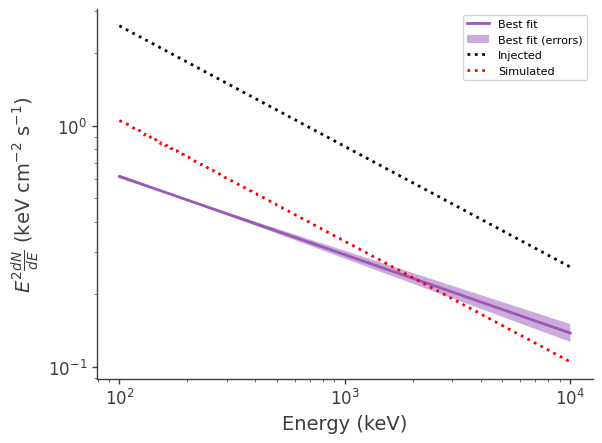

In [19]:
fig,ax = plt.subplots()

ax.plot(energy, energy*energy*flux_median, label = "Best fit")
ax.fill_between(energy, energy*energy*flux_lo, energy*energy*flux_hi, alpha = .5, label = "Best fit (errors)")
ax.plot(energy, energy*energy*flux_inj, color = 'black', ls = ":", label = "Injected")
ax.plot(e_values, e_values*e_values*spec_values, color = 'red', ls = ":", label = "Simulated")


ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel(r"$E^2 \frac{dN}{dE}$ (keV cm$^{-2}$ s$^{-1}$)")

ax.legend()
# fig.savefig('/home/srinadb/cosipy/docs/tutorials/spectral_fits/continuum_fit/4Cp2135/results/spectral_fitting_4cp2135.png')
# plt.cose()

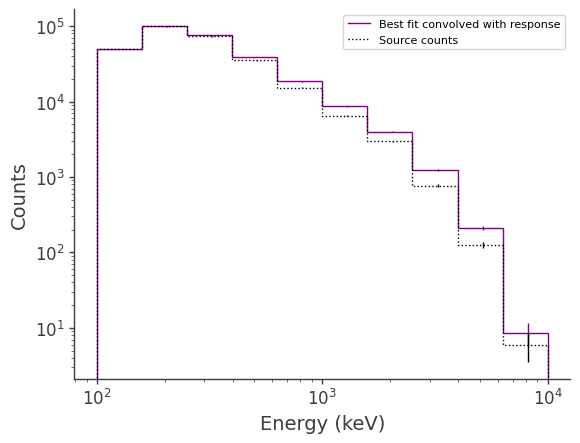

In [20]:
fig,ax = plt.subplots()

ax.stairs(expectation.project('Em').todense().contents, binned_energy_edges, color='purple', label = "Best fit convolved with response")
ax.errorbar(binned_energy, expectation.project('Em').todense().contents, yerr=np.sqrt(expectation.project('Em').todense().contents), color='purple', linewidth=0, elinewidth=1)
ax.stairs(blazar.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Source counts")
ax.errorbar(binned_energy, blazar.binned_data.project('Em').todense().contents, yerr=np.sqrt(blazar.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

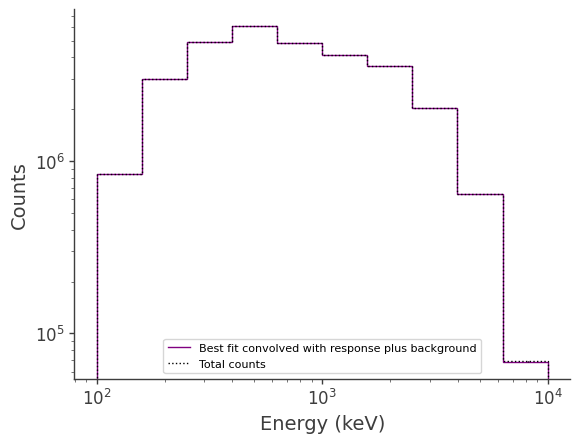

In [21]:
fig,ax = plt.subplots()

ax.stairs(expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents), binned_energy_edges, color='purple', label = "Best fit convolved with response plus background")
ax.errorbar(binned_energy, expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents), yerr=np.sqrt(expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents)), color='purple', linewidth=0, elinewidth=1)
ax.stairs(blazar_bkg.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Total counts")
ax.errorbar(binned_energy, blazar_bkg.binned_data.project('Em').todense().contents, yerr=np.sqrt(blazar_bkg.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

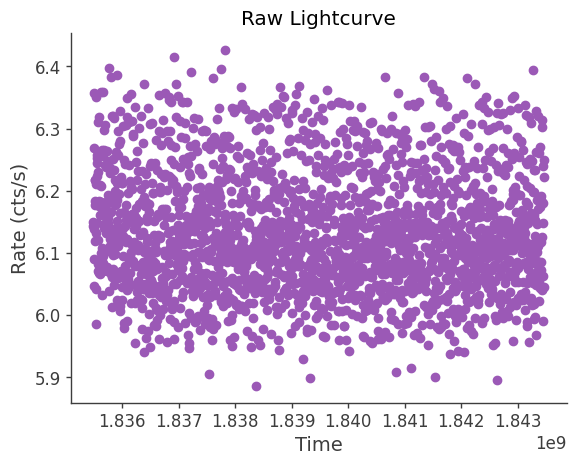

In [18]:
blazar_bkg.get_raw_lightcurve(binned_data=data_path / "4cp2135_albedo_bkg_binned_data.hdf5", output_name="lc_blazar")
time, rate = np.loadtxt("lc_flare.dat", skiprows=1, unpack=True)
plt.scatter(time, rate)
plt.xlabel('Time')
plt.ylabel('Rate (cts/s)')
plt.title('Raw Lightcurve')
# plt.savefig('/home/srinadb/cosipy/docs/tutorials/spectral_fits/continuum_fit/4Cp2135/results/raw_lc_4cp2135.png', dpi=200)
plt.show()
plt.close()

Compute integral flux from the fitted spectrum

#### Method 1 from threeML without error propagation

In [22]:
simulated_flux = 0.017293201590129727


In [25]:
# https://threeml.readthedocs.io/en/latest/notebooks/flux_examples.html
# Get the simulated flux from the below
# https://github.com/cositools/cosi-sim/blob/main/cosi_sim/Source_Library/DC2/sources/Galactic/Crab/Crab.source

threeML_config.point_source.integrate_flux_method = "quad" # trapz, quad
result_fl=results.get_flux(
        ene_min= 100. * u.keV,
        ene_max= 10000. * u.keV,
        confidence_level=0.68,
        sum_sources=True,
        flux_unit="1/(cm2 s)" # 1/(cm2 s) (for integral photon flux) and keV/(cm2 s) or erg/(cm2 s) (for integral photon flux)
    )
print(result_fl)
# fl.flux.apply(lambda x: float(str(x).split()[1])).values[0]

print('\nThe simulated flux is: '+str(simulated_flux)+'\n')
print('Flux from the fitted spectrum (quad) is: '+str(result_fl["flux"].values[0].value)+'')

processing MLE analyses:   0%|                            | 0/1 [00:00<?, ?it/s]

                                  flux                         low bound  \
total  0.00464484608839064 1 / (s cm2)  0.004598439758998179 1 / (s cm2)   

                              hi bound  
total  0.00469190379348634 1 / (s cm2)  

The simulated flux is: 0.017293201590129727

Flux from the fitted spectrum (quad) is: 0.00464484608839064


In [24]:
# https://threeml.readthedocs.io/en/latest/notebooks/flux_examples.html
# Get the simulated flux from the below
# https://github.com/cositools/cosi-sim/blob/main/cosi_sim/Source_Library/DC2/sources/GRBs/GRB090206620/GRB090206620.source

threeML_config.point_source.integrate_flux_method = "trapz" # trapz, quad
result_fl=results.get_flux(
        ene_min= 100. * u.keV,
        ene_max= 10000. * u.keV,
        confidence_level=0.95,
        sum_sources=True,
        flux_unit="1/(cm2 s)" # 1/(cm2 s) (for integral photon flux) and keV/(cm2 s) or erg/(cm2 s) (for integral photon flux)
    )
print(result_fl)
# fl.flux.apply(lambda x: float(str(x).split()[1])).values[0]

print('\nThe simulated flux is: '+str(simulated_flux)+'\n')
print('Flux from the fitted spectrum (trapz) is: '+str(result_fl["flux"].values[0].value)+'')

processing MLE analyses:   0%|                            | 0/1 [00:00<?, ?it/s]

                                   flux                         low bound  \
total  0.007886587329466541 1 / (s cm2)  0.007705982355157565 1 / (s cm2)   

                               hi bound  
total  0.008069379191299091 1 / (s cm2)  

The simulated flux is: 0.017293201590129727

Flux from the fitted spectrum (trapz) is: 0.007886587329466541
